In [26]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [27]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import time
import random

In [28]:
# ------------------------------
# 1. Data Handling & Loading
# ------------------------------

def load_data(path):
    events = pd.read_csv(f"{path}/events_World_Cup.csv", low_memory=False)
    matches = pd.read_csv(f"{path}/matches_World_Cup.csv")
    teams = pd.read_csv(f"{path}/teams.csv")
    players = pd.read_csv(f"{path}/players.csv")
    return events, matches, teams, players

In [29]:
# ------------------------------
# 2. Exploratory Data Analysis
# ------------------------------

def perform_eda(events):
    events['tagsList'] = events['tagsList'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    sub_counts = events['subEventName'].value_counts().head(10)
    print("Top 10 Event Types:\n", sub_counts)
    plt.figure(figsize=(10,5))
    sub_counts.plot(kind='bar')
    plt.title('Top 10 Sub-Event Types')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [30]:
# ------------------------------
# 3. Preprocessing & Feature Engineering
# ------------------------------

def preprocess_and_engineer(events):
    df = events.copy()
    df['tagsList'] = df['tagsList'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else (x if isinstance(x, list) else []))
    df['minute'] = (df['eventSec'] // 60).astype(int)
    df['second'] = (df['eventSec'] % 60).astype(int)
    df['danger_level'] = df['tagsList'].apply(lambda tags: 2 if 101 in tags else (1 if 302 in tags else 0))
    df['dx'] = df['pos_dest_x'] - df['pos_orig_x']
    df['dy'] = df['pos_dest_y'] - df['pos_orig_y']
    df['dist'] = np.sqrt(df['dx']**2 + df['dy']**2)
    features = ['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y', 'minute', 'second', 'dist']
    X = df[features].fillna(0)
    y = df['danger_level']
    return X, y, df

In [31]:
# ------------------------------
# 4. Model Training & Evaluation
# ------------------------------

def train_model(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )
    rf = RandomForestClassifier(random_state=42, class_weight='balanced')
    param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
    gs = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc_ovr', n_jobs=-1)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    y_proba = best.predict_proba(X_test)
    print("ROC AUC Score (OvR, macro-average):\n", roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro'))
    return best

In [32]:
# ------------------------------
# 5. System Simulation for a Specific Match
# ------------------------------

def simulate_match(matches, events, teams, model, team_a, team_b, season_id):
    mask = (
        (matches['seasonId'] == season_id) &
        matches['label'].str.contains(team_a, na=False) &
        matches['label'].str.contains(team_b, na=False)
    )
    match = matches.loc[mask].iloc[0]
    match_id = match['wyId']

    evs = events[events['matchId'] == match_id].copy()
    features = ['pos_orig_x', 'pos_orig_y', 'pos_dest_x', 'pos_dest_y', 'minute', 'second', 'dist']
    X_match = evs[features].fillna(0)
    evs['danger_level_pred'] = model.predict(X_match)

    print(f"\n[Live Stream Simulation] {team_a} vs {team_b} — Real-time highlights:\n")
    for idx, row in evs.iterrows():
        level = row['danger_level_pred']
        minute = int(row['minute'])
        second = int(row['second'])
        action = row['subEventName'] if pd.notna(row['subEventName']) else "Unknown Event"
        if level == 1:
            print(f"[{minute:02d}:{second:02d}] ⚠️ Medium Threat: {action}")
        elif level == 2:
            phrase = random.choice([
                "What a moment!",
                "Tension rising on the pitch!",
                "Fans are on the edge of their seats!",
                "A potential turning point!",
                "The game could change right here!"
            ])
            print(f"[{minute:02d}:{second:02d}] 🔥 HIGH Danger: {action} — {phrase}")
        elif level == 0:
            continue
        time.sleep(0.1)

Top 10 Event Types:
 subEventName
Simple pass               45048
Ground attacking duel      8072
Ground defending duel      8007
Touch                      6403
Air duel                   5518
Ground loose ball duel     4330
High pass                  4040
Head pass                  2918
Throw in                   2607
Clearance                  1931
Name: count, dtype: int64


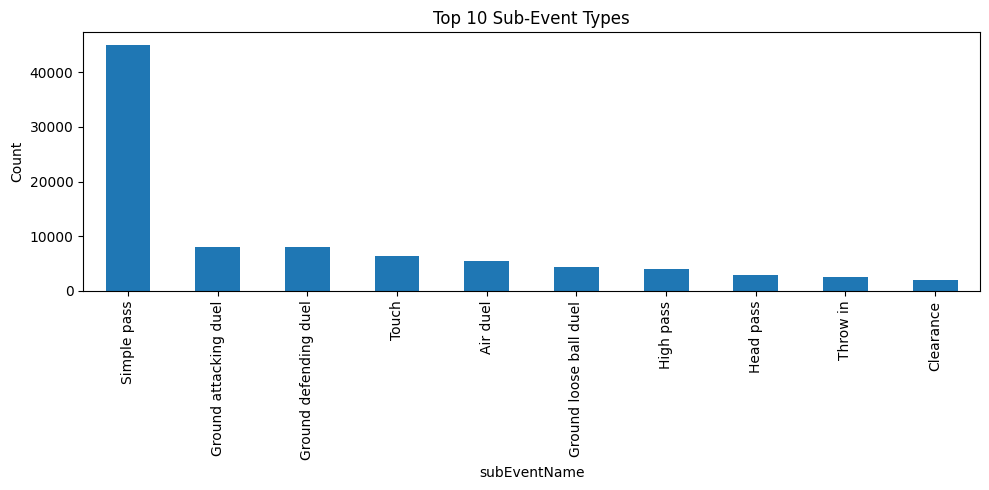

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     20188
           1       0.99      1.00      0.99     20188
           2       0.99      1.00      1.00     20189

    accuracy                           0.99     60565
   macro avg       0.99      0.99      0.99     60565
weighted avg       0.99      0.99      0.99     60565

Confusion Matrix:
 [[19774   248   166]
 [   13 20173     2]
 [    2     2 20185]]
ROC AUC Score (OvR, macro-average):
 0.9998582400925056

[Live Stream Simulation] Saudi Arabia vs Russia — Real-time highlights:

[08:41] ⚠️ Medium Threat: Cross
[10:48] ⚠️ Medium Threat: Simple pass
[11:33] 🔥 HIGH Danger: Shot — The game could change right here!
[11:35] 🔥 HIGH Danger: Reflexes — What a moment!
[23:48] ⚠️ Medium Threat: Air duel
[30:17] ⚠️ Medium Threat: Free kick cross
[42:12] 🔥 HIGH Danger: Shot — The game could change right here!
[42:14] 🔥 HIGH Danger: Reflexes — Tension rising on the pi

In [33]:
# ------------------------------
# 6. Main Pipeline
# ------------------------------

def main(data_path):
    events, matches, teams, players = load_data(data_path)
    perform_eda(events)
    X, y, events_proc = preprocess_and_engineer(events)
    model = train_model(X, y)

    simulate_match(
        matches, events_proc, teams, model,
        team_a='Saudi Arabia', team_b='Russia', season_id=10078
    )

if __name__ == '__main__':
    DATA_PATH = '/kaggle/input/soccer-match-event-dataset'
    main(DATA_PATH)